# Zucchero sintattico {#sec-bambi}

**Prerequisiti**

**Concetti e competenze chiave**

- Utilizzare Bambi per costruire e adattare modelli.
- Analizzare i risultati con Bambi.

**Preparazione del Notebook**

In [5]:
import os
import logging
import pandas as pd
import numpy as np
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
import cmdstanpy

cmdstanpy.utils.get_logger().setLevel(logging.ERROR)
from cmdstanpy import CmdStanModel
import bambi as bmb

In [6]:
seed: int = sum(map(ord, "bambi"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Get the home directory
home_directory = os.path.expanduser("~")
# Construct the path to the Quarto project directory
project_directory = os.path.join(home_directory, "_repositories", "psicometria")

## Introduzione

I modelli lineari sono così ampiamente utilizzati che sono stati sviluppati appositamente una sintassi, dei metodi e delle librerie per la regressione. Una di queste librerie è `bambi` (BAyesian Model-Building Interface). `bambi` è un pacchetto Python progettato per adattare modelli gerarchici generalizzati lineari (di cui il modello lineare bivariato è un caso particolare), utilizzando una sintassi simile a quella presente nei pacchetti R, come `lme4`, `nlme`, `rstanarm` o `brms`. `bambi` si basa su PyMC, ma offre un'API di livello superiore.

In questo capitolo esploreremo come condurre un'analisi di regressione utilizzando `bambi` invece di cmdstan.

## BAyesian Model-Building Interface 

Leggiamo i dati utilizzati nel capitolo precedente.

In [8]:
data_file = os.path.join(project_directory, "data", "Howell_18.csv")
df = pd.read_csv(data_file)

Generiamo un diagramma a dispersione:

Text(0, 0.5, 'Height')

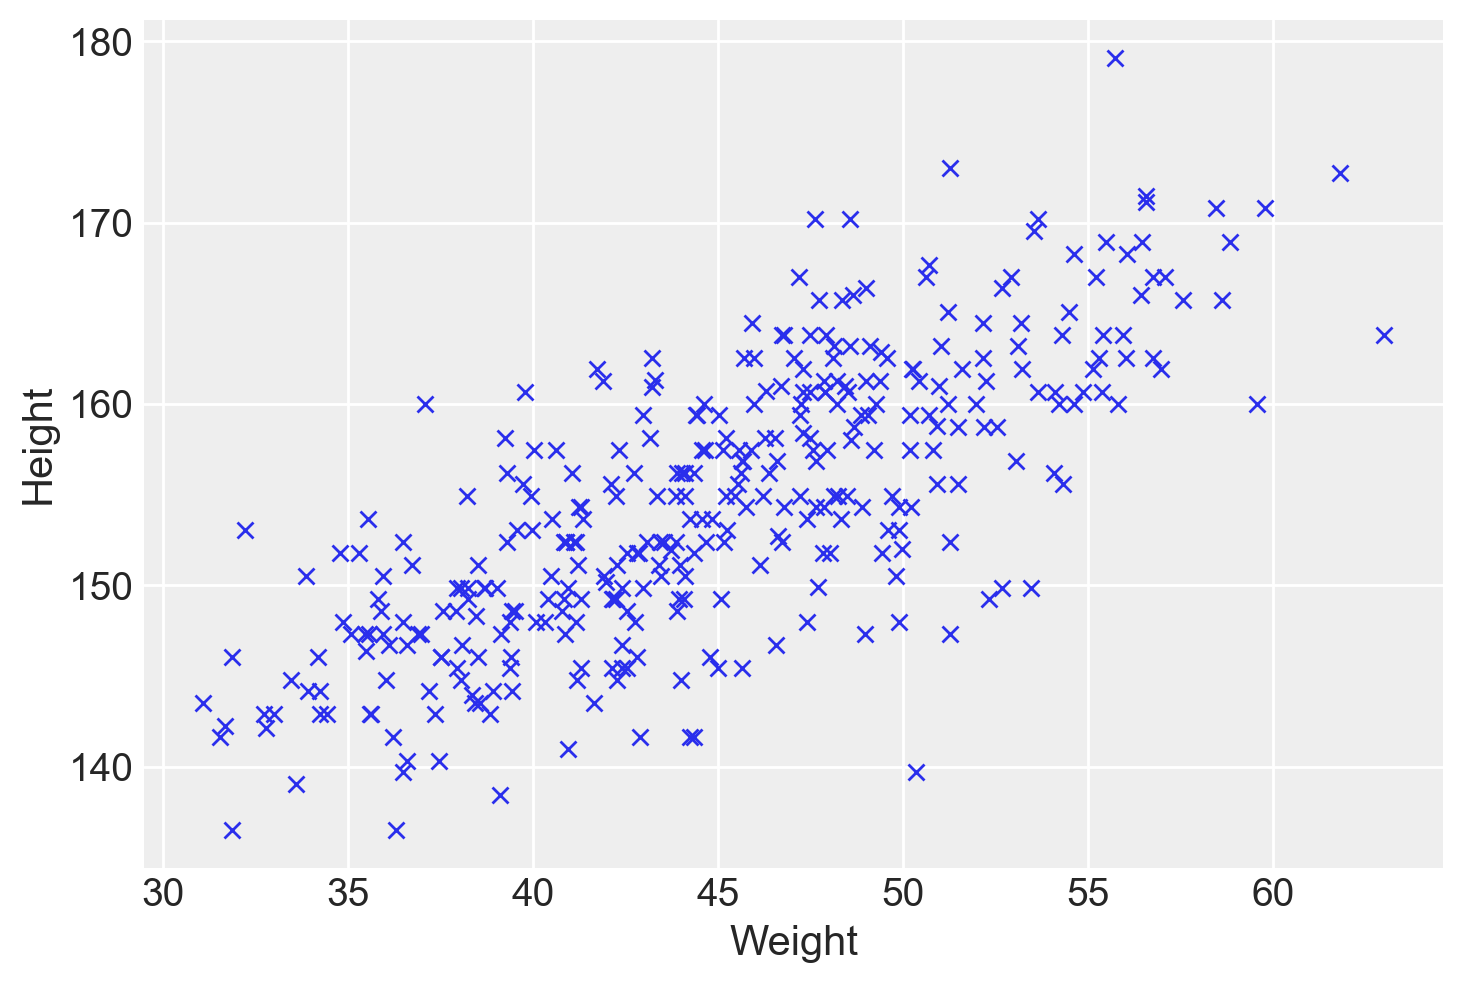

In [9]:
plt.plot(df["weight"], df["height"], "x")
plt.xlabel("Weight")
plt.ylabel("Height")

Bambi si concentra sui modelli di regressione, e questa specializzazione permette di adottare una sintassi più semplice, conosciuta come sintassi di Wilkinson [@wilkinson1973symbolic].

Ad esempio, il modello $y = \alpha + \beta x + \varepsilon$ si implementa come segue:

```python
a_model = bmb.Model("y ∼ x", data)
```

Nella sintassi di Wilkinson, il simbolo tilde (∼) separa la variabile dipendente (a sinistra) dalle variabili indipendenti (a destra). In questo caso, stiamo specificando solo la media ($\mu$ nel modello lm di PyMC). Bambi assume di default che la distribuzione di verosimiglianza sia gaussiana, ma è possibile modificarla tramite l'argomento `family`.

Se desideriaamo escludere l'intercetta dal modello, possiamo farlo in questo modo:

```python
no_intercept_model = bmb.Model("y ∼ 0 + x", data)
```

Oppure in questo modo:

```python
no_intercept_model = bmb.Model("y ∼ -1 + x", data)
```

Per includere ulteriori variabili nel modello, possiamo procedere così:

```python
model_2 = bmb.Model("y ∼ x + z", data)
```

Bambi consente anche di includere effetti a livello di gruppo (gerarchici). Ad esempio, se desideriamo un modello ad effetti misti nel quale abbiamo un effetto diverso di $x$ in ciascun gruppo `g`, possiamo usare la seguente sintassi:

```python
model_h = bmb.Model("y ∼ x + z + (x | g)", data)
```

La sintassi delle formule non specifica le distribuzioni a priori, ma solo come le variabili dipendenti e indipendenti sono collegate. Bambi definirà automaticamente delle distribuzioni a priori debolmente informative per noi.

Inoltre, Bambi implementa di default delle distribuzioni a priori debolmente informative, rendendo superflua la loro definizione esplicita. Tuttavia, se preferisci avere un maggiore controllo, possiamo specificarle manualmente.

Per replicare il modello descritto nel capitolo precedente, possiamo utilizzare la seguente istruzione:

In [10]:
df["weight_c"] = df["weight"] - np.mean(df["weight"])

model = bmb.Model("height ~ weight_c", df)

Sul lato sinistro della tilde (∼), abbiamo la variabile dipendente, e sul lato destro, le variabili indipendenti. Con questa sintassi, stiamo semplicemente specificando la media (μ nel modello lm di PyMC). Per impostazione predefinita, Bambi assume che la verosimiglianza sia gaussiana; è possibile modificarla con l'argomento `family`. La sintassi della formula non specifica la distribuzione delle priors, ma solo come sono associate le variabili dipendenti e indipendenti. Bambi definirà automaticamente delle priors (molto) debolmente informative per noi. Possiamo ottenere ulteriori informazioni stampando il modello Bambi.

In [11]:
print(model)

       Formula: height ~ weight_c
        Family: gaussian
          Link: mu = identity
  Observations: 352
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 154.5971, sigma: 19.3283)
            weight_c ~ Normal(mu: 0.0, sigma: 2.9978)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 7.7313)


La descrizione inizia mostrando la formula utilizzata per definire il modello, `y ~ x`, che indica come la variabile dipendente `y` è predetta dalla variabile indipendente `x` in una relazione lineare. La seconda riga specifica che si sta utilizzando una distribuzione gaussiana (normale) come funzione di verosimiglianza per il modello, il che implica l'assunzione che i residui del modello (le differenze tra i valori osservati e i valori predetti) seguano una distribuzione normale.

La terza riga menziona la funzione di collegamento, in questo caso l'identità, che non applica alcuna trasformazione al valore atteso della variabile dipendente. Questo è caratteristico dei modelli lineari, dove il valore atteso di `y` è direttamente modellato come una combinazione lineare delle variabili indipendenti (`E(Y) = \alpha + \beta x`). È importante notare che, nei modelli lineari generalizzati, la funzione di collegamento gioca un ruolo cruciale nel collegare il valore atteso della variabile risposta alla combinazione lineare delle variabili predittive.

Segue il numero di osservazioni utilizzate per adattare il modello, indicando la dimensione del dataset su cui il modello è stato allenato.

La parte successiva dell'output dettaglia i priors utilizzati per i parametri del modello. In Bambi, i priors sono assunzioni a priori sui valori dei parametri prima di osservare i dati. Questi priors aiutano a guidare l'inferenza, soprattutto in presenza di dati limitati o per regolarizzare il modello. L'intercetta (Intercept) ha un prior normale con media (`mu`) 2.0759 e deviazione standard (`sigma`) 3.9401, indicando la posizione iniziale attesa della linea di regressione e quanto ci si aspetta che vari. Il coefficiente della variabile `x` ha anch'esso un prior normale, centrato in zero con una deviazione standard ampia (6.8159), riflettendo incertezza su quale possa essere il vero effetto di `x` su `y` senza presupporre una direzione specifica dell'effetto.

La sezione finale riguarda i parametri ausiliari del modello, in questo caso il parametro `sigma` della distribuzione gaussiana, che rappresenta la deviazione standard dei residui del modello. Questo ha un prior HalfStudentT, che è una distribuzione che ammette solo valori positivi (essendo la deviazione standard sempre positiva), con un grado di libertà (`nu`) 4.0 e una scala (`sigma`) 0.791. Questo prior è scelto per la sua flessibilità e la capacità di gestire dati con potenziali outlier.

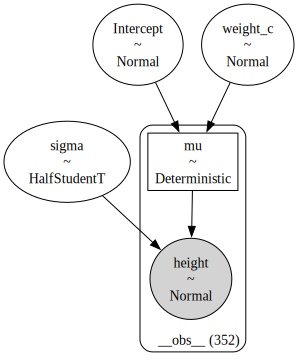

In [12]:
model.build()
model.graph()

Se vogliamo procedere con un'ispezione visiva dei prior dei parametri del modello usiamo:

Sampling: [Intercept, sigma, weight_c]


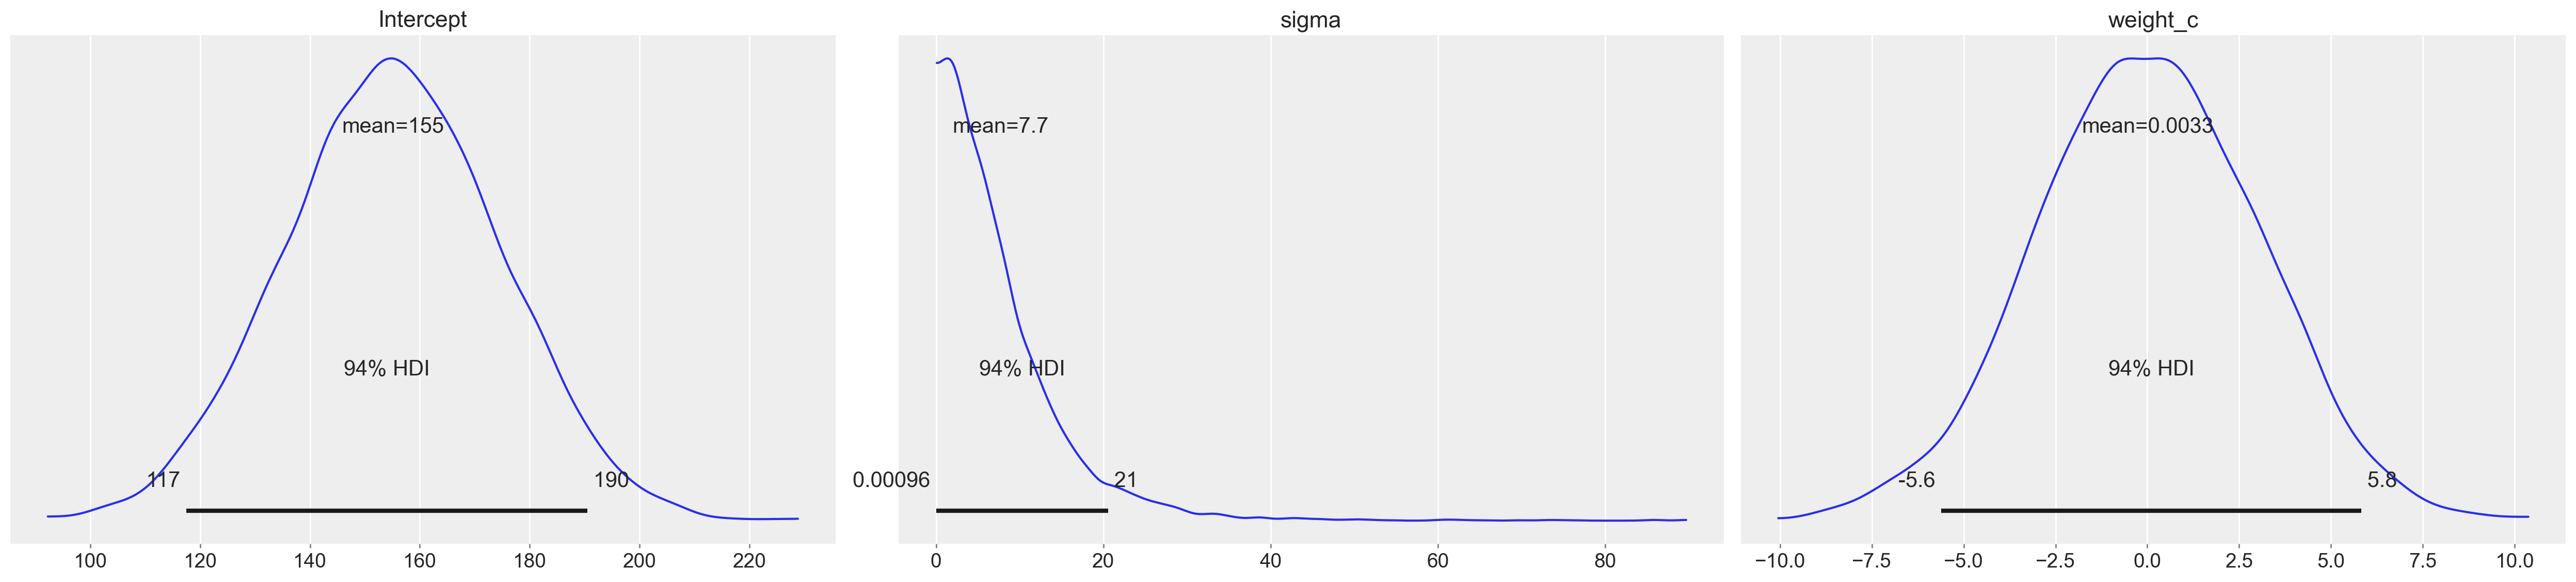

In [14]:
_ = model.plot_priors()

Eseguiamo il campionamento MCMC.

In [15]:
idata = model.fit(
    nuts_sampler="numpyro",
    idata_kwargs={"log_likelihood": True}
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Le distribuzioni a posteriori dei parametri e i trace plot si ottengono con la seguente istruzione.

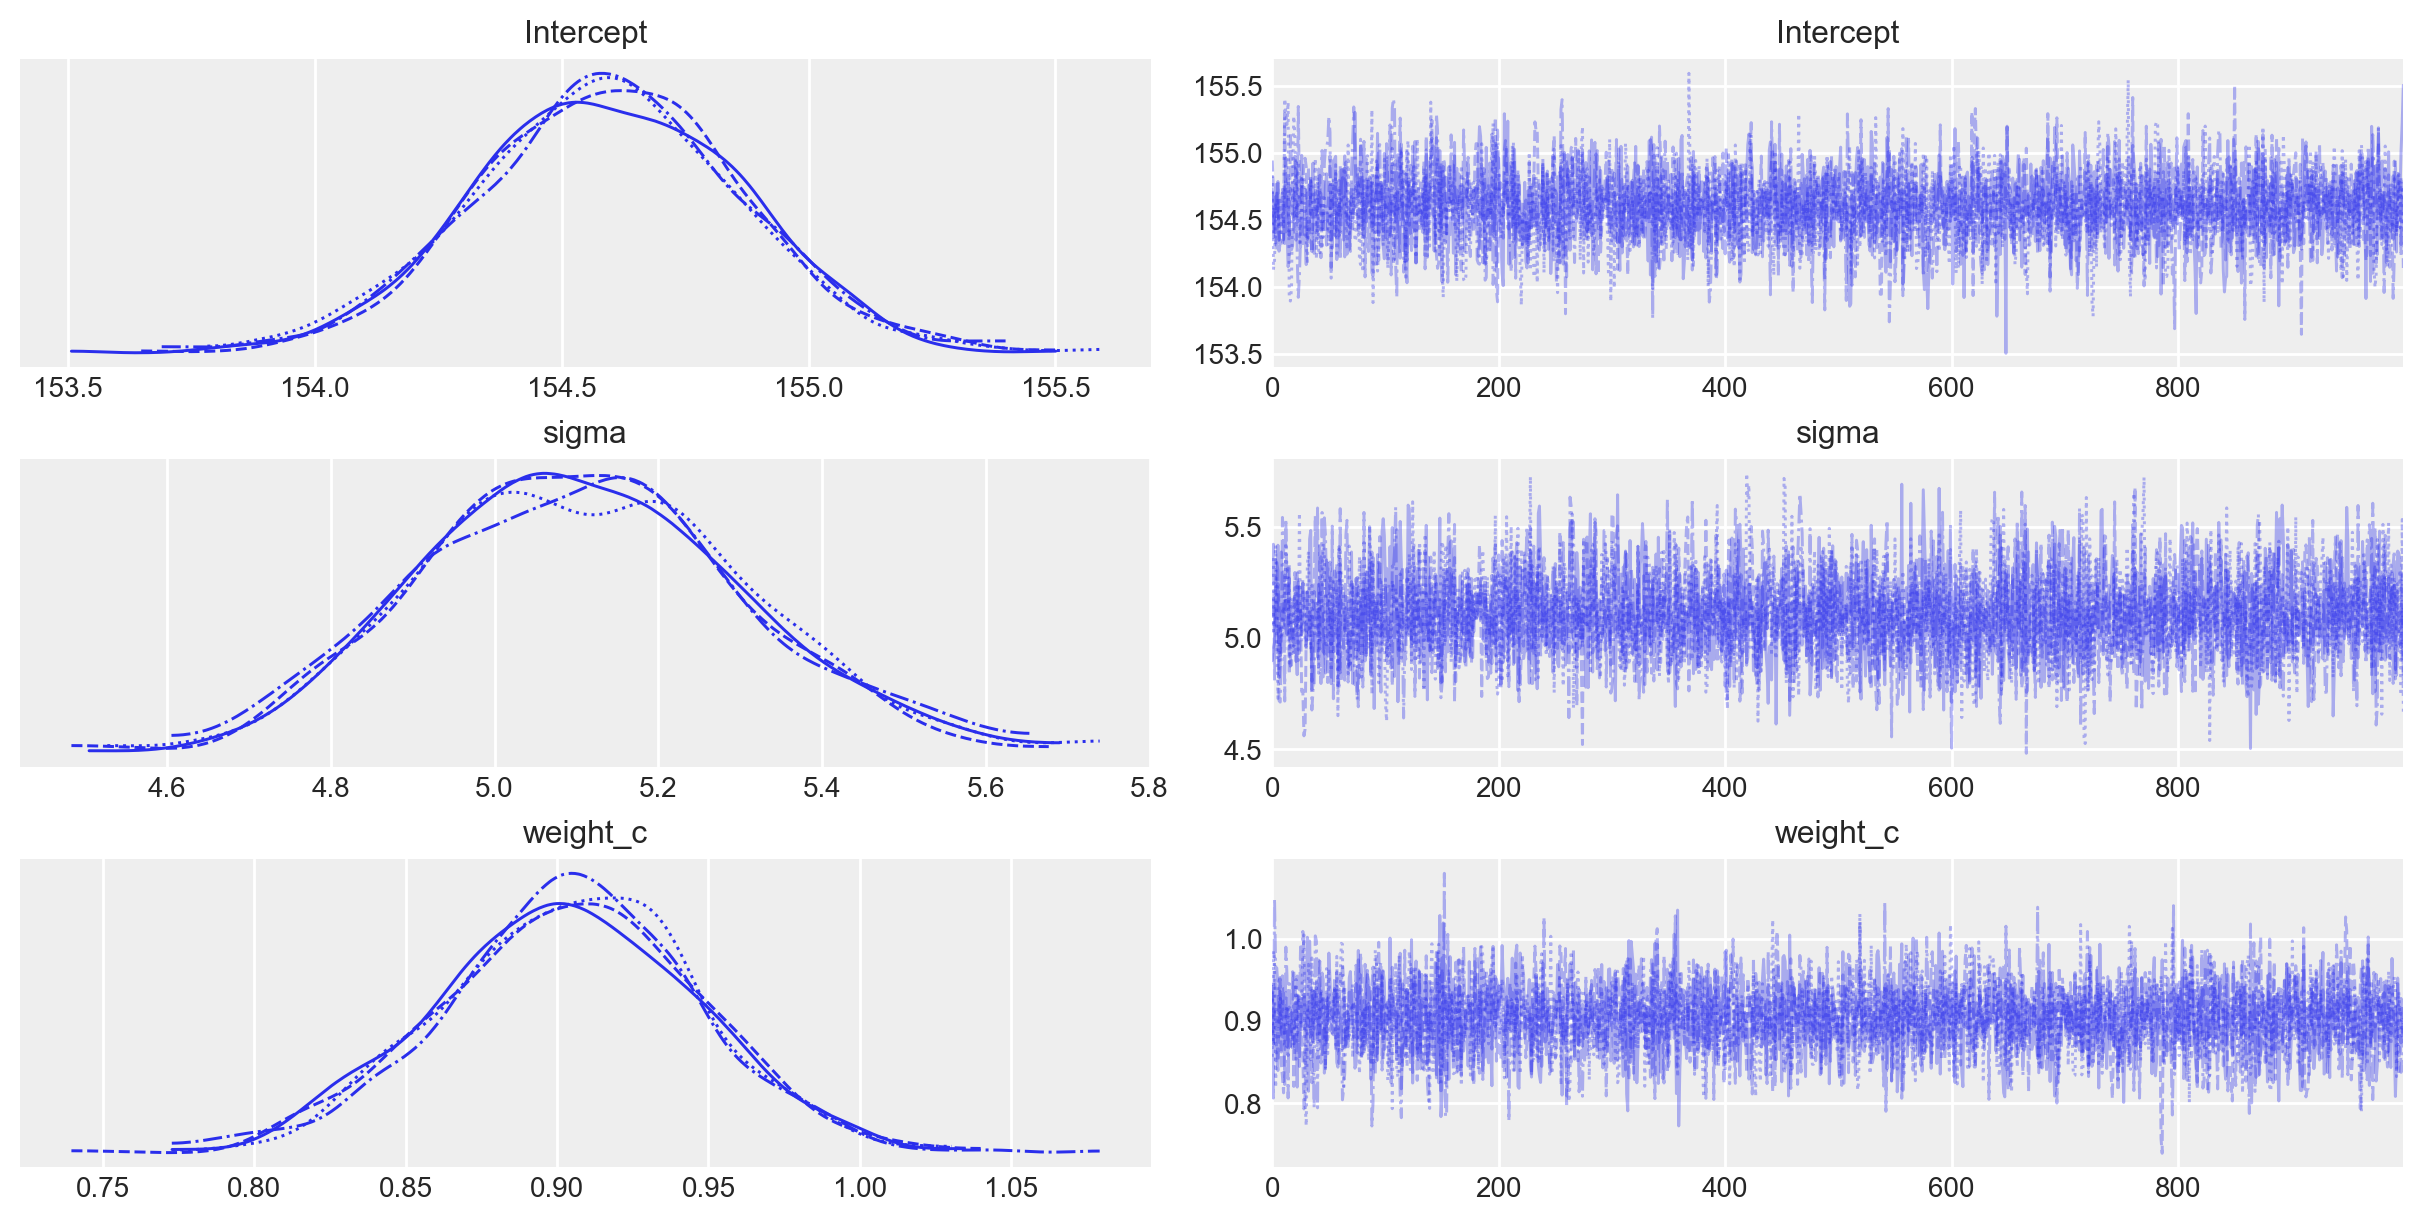

In [16]:
_ = az.plot_trace(idata)

Un sommario numerico delle distribuzioni a posteriori dei parametri si ottiene con `az.summary`.

In [17]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,154.59,0.27,154.07,155.07,0.0,0.0,4100.84,2810.35,1.0
sigma,5.11,0.20,4.74,5.46,0.0,0.0,4391.39,2834.61,1.0
weight_c,0.90,0.04,0.82,0.98,0.0,0.0,4522.69,3091.93,1.0


I dati replicano quelli ottenuti in precedenza.

Possiamo anche generare un grafico che descrive l'incertezza a posteriori delle predizioni del modello. 

La funzione `plot_predictions` del pacchetto Bambi serve per facilitare l'interpretazione dei modelli di regressione attraverso la visualizzazione grafica. Il metodo appartiene al sottomodulo `interpret` di Bambi e si concentra sulla rappresentazione delle previsioni generate dal modello.

Quando si esegue la funzione `plot_predictions` con i parametri specificati (`model`, `idata`, `["weight_c"]`), essa produce un grafico che sintetizza le previsioni del modello in relazione a una o più variabili indipendenti. In questo caso, il parametro `model` indica il modello di regressione Bayesiana costruito con Bambi, `idata` rappresenta i dati inferenziali (ottenuti tramite il fit del modello), e `["weight_c"]` specifica la variabile indipendente da considerare per il grafico.

Default computed for conditional variable: weight_c


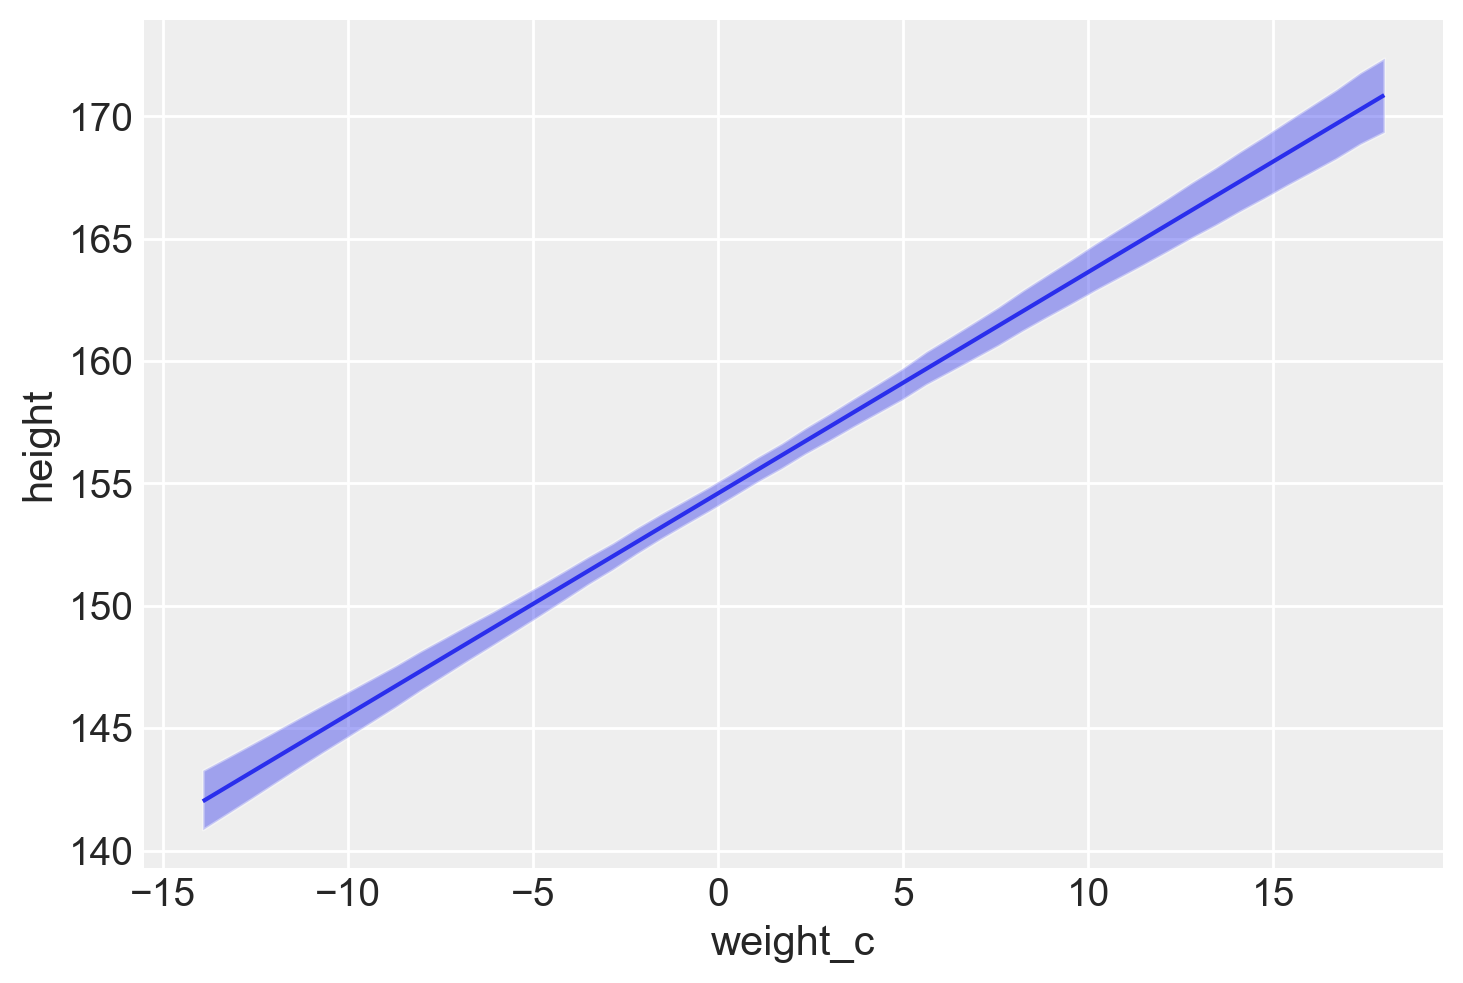

In [18]:
bmb.interpret.plot_predictions(model, idata, ["weight_c"]);

Il grafico generato da questa funzione illustra due aspetti principali:

1. **Media Posteriore di `y`**: Il grafico include una linea che rappresenta la media posteriore della variabile dipendente (`height`) rispetto alla variabile indipendente specificata (`weight_c`). La media posteriore è una stima centrale delle previsioni del modello, che riflette la posizione più probabile dei valori di `height` data l'evidenza fornita dai dati.

2. **Intervallo di Densità più Alta del 94%**: Attorno alla retta della media posteriore, il grafico mostra anche un'area evidenziata che rappresenta l'intervallo di densità più alta (HDI) del 94%. Questo intervallo è un modo per quantificare l'incertezza delle previsioni del modello. L'HDI del 94% significa che, data la distribuzione posteriore delle previsioni di `height`, c'è il 94% di probabilità che il valore vero di `height` cada all'interno di questo intervallo per un dato valore di `weight_c`. Questo fornisce una misura visiva dell'incertezza associata alle stime del modello.

## Informazioni sull'Ambiente di Sviluppo

In [19]:
%load_ext watermark
%watermark -n -u -v -iv -w -m 

Last updated: Wed Aug 14 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

seaborn   : 0.13.2
cmdstanpy : 1.2.4
arviz     : 0.18.0
matplotlib: 3.9.1
pandas    : 2.2.2
numpy     : 1.26.4
logging   : 0.5.1.2
bambi     : 0.14.0

Watermark: 2.4.3

